In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import lightgbm as lgb
import xgboost as xgb
import missingno as msno

In [2]:
pd.options.display.max_rows = 222
pd.set_option("display.max_columns", 50)

In [3]:
df_train = pd.read_csv(
    "../geekbrains-competitive-data-analysis/train.csv"
)

df_test = pd.read_csv(
    "../geekbrains-competitive-data-analysis/test.csv"
)

print("gf_train.shape = {} rows, {} cols".format(*df_train.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))

gf_train.shape = 110093 rows, 3 cols
df_test.shape = 165141 rows, 2 cols


In [45]:
#df_train = create_dummie(df_train)
#df_test = create_dummie(df_test)

df_train['NAME_CONTRACT_TYPE'] = (df_train['NAME_CONTRACT_TYPE'] == 'Cash').astype(int)
df_test['NAME_CONTRACT_TYPE'] = (df_test['NAME_CONTRACT_TYPE'] == 'Cash').astype(int)

In [4]:
# df_sample_submit = pd.read_csv(
#     "../geekbrains-competitive-data-analysis/sample_submit.csv"
# )

# print("sample_submit.shape = {} rows, {} cols".format(*df_sample_submit.shape))
# df_sample_submit.head()

# функции

In [5]:
def create_freq_feature(data: pd.DataFrame,
                        feature: str
                       ) -> pd.DataFrame:
    freq = data[feature].value_counts()
    data[feature] = data[feature].map(freq).astype('float')
    data[feature] = data[feature].fillna(0.0).astype('float')
    data[feature] = data[feature] / data.shape[0]
    
    return data

In [6]:
def numeric_feature_preprocessing(data: pd.DataFrame,
                         numeric_feature=list()) -> pd.DataFrame:
    
    if len(numeric_feature) == 0:
        numeric_feature = data.select_dtypes(include=[np.number]).columns
    
    for feature in numeric_feature:
        max_ = data[feature].quantile(.99)
        min_ = data[feature].quantile(.01)
        data.loc[data[feature] > max_, [feature]] = max_
        data.loc[data[feature] < min_, [feature]] = min_
        
    return data

In [7]:
def create_dummie(data: pd.DataFrame) -> pd.DataFrame:
    """
    

    """
    numeric_feature = data.select_dtypes(include=[np.number]).columns

    сategorical_feature = list(set(data.columns) - set(numeric_feature))

    data_copy = data.copy()

    for i in range(len(сategorical_feature)):
        print(f'feature {сategorical_feature[i]}')
        сategorical_values = data_copy[сategorical_feature[i]].unique()
        print(f'сategorical values {сategorical_values}')

        for cat in сategorical_values:
            dummie_feature_name = f'{сategorical_feature[i]}_{cat}'

            if str(cat) != 'nan':
                print(f'    dummie feature name: {dummie_feature_name}')
                data_copy[f'{сategorical_feature[i]}_{cat}'] = 0
                data_copy.loc[data_copy.loc[:,сategorical_feature[i]]==cat, 
                                                 [dummie_feature_name]] = 1      

        data_copy.drop([сategorical_feature[i]], axis='columns', inplace=True)

    print(f"count of data {data_copy.shape}")
    return data_copy

# история предыдущих заявок клиента.
df_applications_history

In [8]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# история предыдущих заявок клиента.
df_applications_history = pd.read_csv(
    "../geekbrains-competitive-data-analysis/applications_history.csv"
)

print("applications_history.shape = {} rows, {} cols".format(*df_applications_history.shape))
df_applications_history.head()

applications_history.shape = 1670214 rows, 26 cols


,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,-1,12.0,high,365243.0,271.0,59.0,365243.0,365243.0,1.0
3,50087457,123499497,Cash,47041.335,450000.0,470790.0,NaN,450000.0,Approved,512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,-1,12.0,middle,365243.0,482.0,152.0,182.0,177.0,1.0
4,49052479,123525393,Cash,31924.395,337500.0,404055.0,NaN,337500.0,Refused,781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,-1,24.0,high,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

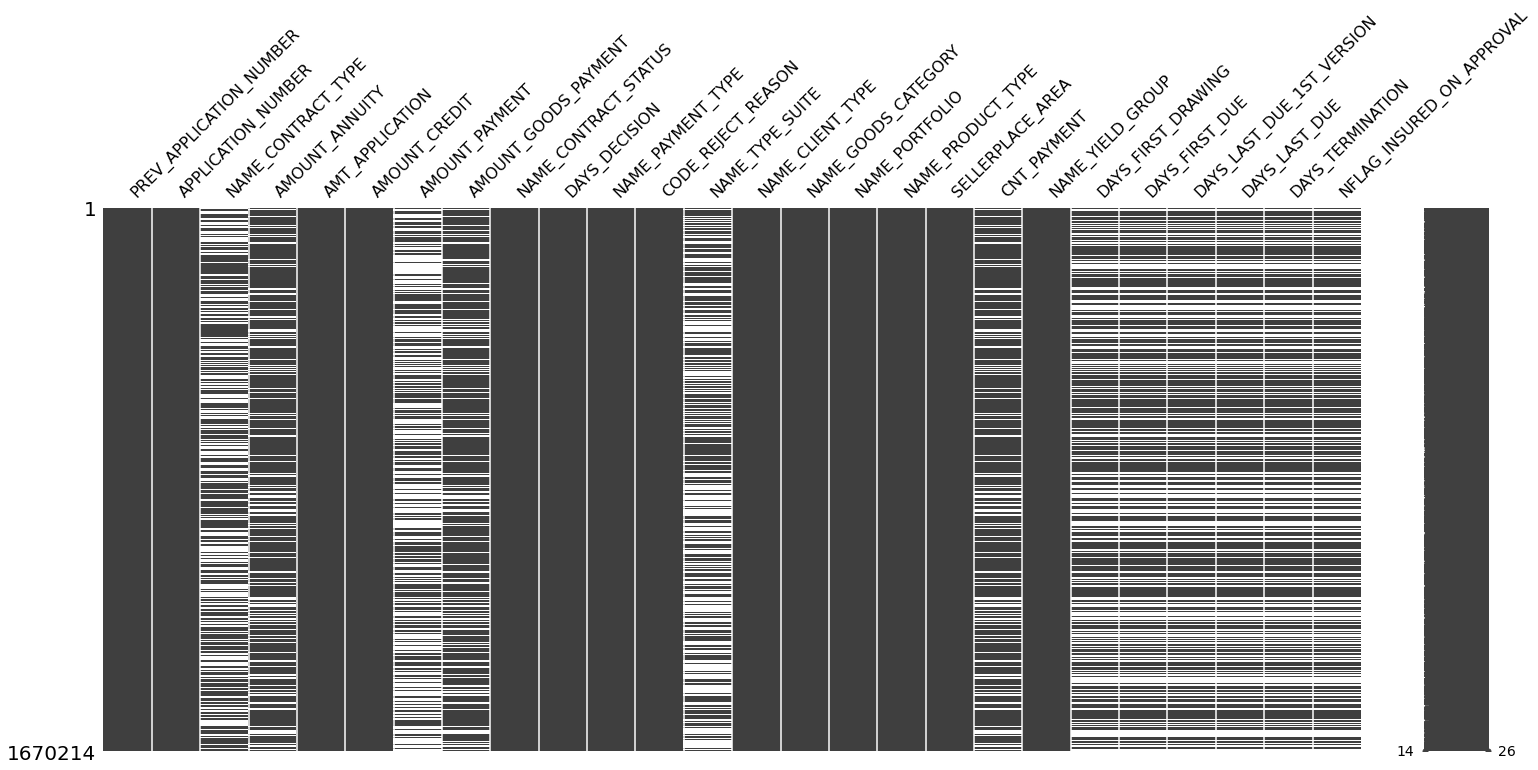

In [9]:
msno.matrix(df_applications_history)

In [10]:
numerical_features_df_applications_history = df_applications_history.select_dtypes(include=[np.number]).columns
numerical_features_df_applications_history = numerical_features_df_applications_history.drop('APPLICATION_NUMBER')
numerical_features_df_applications_history = numerical_features_df_applications_history.drop('PREV_APPLICATION_NUMBER')
numerical_features_df_applications_history

Index(['AMOUNT_ANNUITY', 'AMT_APPLICATION', 'AMOUNT_CREDIT', 'AMOUNT_PAYMENT',
       'AMOUNT_GOODS_PAYMENT', 'DAYS_DECISION', 'SELLERPLACE_AREA',
       'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

NAME_CONTRACT_TYPE

In [11]:
df_applications_history['NAME_CONTRACT_TYPE'].value_counts()

Cash           747553
Credit Card    193164
Name: NAME_CONTRACT_TYPE, dtype: int64

In [12]:
df_applications_history = create_freq_feature(df_applications_history, 'NAME_CONTRACT_TYPE')

AMOUNT_ANNUITY, AMOUNT_GOODS_PAYMENT

In [13]:
df_applications_history = df_applications_history.fillna(value=
                                                         {'AMOUNT_ANNUITY': 0, 
                                                          'AMOUNT_GOODS_PAYMENT': 0})

AMOUNT_PAYMENT

In [14]:
df_applications_history.drop(['AMOUNT_PAYMENT'], axis='columns', inplace=True)
numerical_features_df_applications_history = numerical_features_df_applications_history.drop('AMOUNT_PAYMENT')

NAME_TYPE_SUITE

In [15]:
df_applications_history['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      508970
Family             213263
Spouse, partner     67069
Children            31566
Other_B             17624
Other_A              9077
Group of people      2240
Name: NAME_TYPE_SUITE, dtype: int64

In [16]:
df_applications_history = create_freq_feature(df_applications_history, 'NAME_TYPE_SUITE')

NAME_CONTRACT_STATUS

In [17]:
df_applications_history['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [18]:
freq = pd.Series(data=[1, 0, 0.5, 0.5], index=['Approved', 'Canceled', 'Refused', 'Unused offer'], dtype='float')
df_applications_history['NAME_CONTRACT_STATUS'] = df_applications_history['NAME_CONTRACT_STATUS'].map(freq).astype('float')

NAME_PAYMENT_TYPE

In [19]:
df_applications_history['NAME_PAYMENT_TYPE'].value_counts()

Cash through the bank                        1033552
XNA                                           627384
Non-cash from your account                      8193
Cashless from the account of the employer       1085
Name: NAME_PAYMENT_TYPE, dtype: int64

In [20]:
df_applications_history = create_freq_feature(df_applications_history, 'NAME_PAYMENT_TYPE')

CODE_REJECT_REASON

In [21]:
df_applications_history['CODE_REJECT_REASON'].value_counts()

XAP       1353093
HC         175231
LIMIT       55680
SCO         37467
CLIENT      26436
SCOFR       12811
XNA          5244
VERIF        3535
SYSTEM        717
Name: CODE_REJECT_REASON, dtype: int64

In [22]:
df_applications_history = create_freq_feature(df_applications_history, 'CODE_REJECT_REASON')

NAME_CLIENT_TYPE

In [23]:
df_applications_history['NAME_CLIENT_TYPE'].value_counts()

Repeater     1231261
New           301363
Refreshed     135649
XNA             1941
Name: NAME_CLIENT_TYPE, dtype: int64

In [24]:
df_applications_history = create_freq_feature(df_applications_history, 'NAME_CLIENT_TYPE')

NAME_GOODS_CATEGORY

In [25]:
df_applications_history['NAME_GOODS_CATEGORY'].value_counts()

XNA                         950809
Mobile                      224708
Consumer Electronics        121576
Computers                   105769
Audio/Video                  99441
Furniture                    53656
Photo / Cinema Equipment     25021
Construction Materials       24995
Clothing and Accessories     23554
Auto Accessories              7381
Jewelry                       6290
Homewares                     5023
Medical Supplies              3843
Vehicles                      3370
Sport and Leisure             2981
Gardening                     2668
Other                         2554
Office Appliances             2333
Tourism                       1659
Medicine                      1550
Direct Sales                   446
Fitness                        209
Additional Service             128
Education                      107
Weapon                          77
Insurance                       64
Animals                          1
House Construction               1
Name: NAME_GOODS_CAT

In [26]:
df_applications_history = create_freq_feature(df_applications_history, 'NAME_GOODS_CATEGORY')

NAME_PORTFOLIO, NAME_PRODUCT_TYPE, NAME_YIELD_GROUP

In [27]:
df_applications_history = create_freq_feature(df_applications_history, 'NAME_PORTFOLIO')
df_applications_history = create_freq_feature(df_applications_history, 'NAME_PRODUCT_TYPE')
df_applications_history = create_freq_feature(df_applications_history, 'NAME_YIELD_GROUP')

Other

In [28]:
df_applications_history = df_applications_history.fillna(0)

numeric

In [29]:
df_applications_history = numeric_feature_preprocessing(df_applications_history, 
                                                        numeric_feature=numerical_features_df_applications_history)

visual

In [30]:
standard_scaler = StandardScaler()
df_applications_history_scale = \
            pd.DataFrame(standard_scaler.fit_transform(df_applications_history), 
                         columns=df_applications_history.columns)

In [31]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, learning_rate=250, random_state=42)

In [32]:
df_applications_history_scale.drop(['PREV_APPLICATION_NUMBER', 'APPLICATION_NUMBER'], axis='columns', inplace=True)

In [33]:
df_applications_history_scale.head()

,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,-1.001409,-0.772169,-0.573747,-0.592945,-0.573784,0.719819,-1.037762,0.765301,0.483189,-0.827814,0.594529,-0.903277,1.049797,0.733906,-0.326416,-0.032795,-0.052810,0.887348,-0.168728,-0.246329,-0.384563,-0.399381,-0.497734
1,1.095945,0.956742,1.629294,1.654545,1.629080,0.719819,-0.920786,-1.198692,0.483189,1.439133,0.594529,0.863737,-0.273491,-1.062749,-0.381112,1.625877,-2.840878,0.887348,-0.167090,-0.238996,2.628155,2.528435,2.009104
2,1.095945,0.210299,-0.217909,-0.188245,-0.217974,0.719819,-0.744680,0.765301,0.483189,-0.529089,0.594529,0.863737,-0.273491,-1.062749,-0.381112,-0.032795,-0.358708,0.887348,-0.164652,-0.249198,2.628155,2.528435,2.009104
3,1.095945,2.567328,1.041547,0.945957,1.041381,0.719819,-0.473451,0.765301,0.483189,-0.827814,0.594529,0.863737,-0.273491,-1.062749,-0.381112,-0.032795,-0.052810,0.887348,-0.160896,-0.248091,-0.383408,-0.398259,2.009104
4,1.095945,1.453182,0.621729,0.719571,0.621596,-0.546039,-0.127667,0.765301,-1.935679,-0.827814,0.594529,0.863737,-0.273491,-1.967988,-0.381112,0.796541,-0.358708,-1.127438,-0.169475,-0.249900,-0.384909,-0.399678,-0.497734


In [34]:
%%time

applications_history_tsne = tsne.fit_transform(df_applications_history_scale.sample(2000))

Wall time: 11.9 s


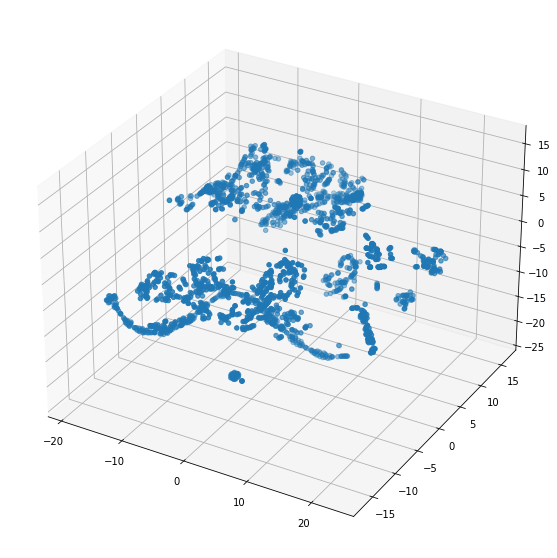

In [35]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [10, 10]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(applications_history_tsne[:, 0],
        applications_history_tsne[:, 1],
        applications_history_tsne[:, 2])

result

In [48]:
kmeans_n_clusters_df_applications_history = 20

kmeans = KMeans(n_clusters=kmeans_n_clusters_df_applications_history,
                max_iter=10000, random_state=1)

In [49]:
%%time

kmeans_train = kmeans.fit_predict(df_applications_history_scale)

Wall time: 1min 58s


In [50]:
df_applications_history_result = pd.DataFrame(pd.get_dummies(kmeans_train, prefix='applications_history'))
df_applications_history_result_columns = df_applications_history_result.columns
df_applications_history_result['APPLICATION_NUMBER'] = df_applications_history['APPLICATION_NUMBER']

In [51]:
df_applications_history_result = pd.pivot_table(df_applications_history_result, 
                                                values=df_applications_history_result_columns, 
                                                index=['APPLICATION_NUMBER'], aggfunc=np.sum)

In [52]:
df_applications_history_result['sum'] = df_applications_history_result.sum(axis=1)
for col in df_applications_history_result_columns:
    df_applications_history_result[col] = df_applications_history_result[col] / df_applications_history_result['sum']
df_applications_history_result.drop(['sum'], axis='columns', inplace=True)  

## model

In [59]:
# df_applications_history_result = pd.pivot_table(df_applications_history, 
#                                                 values=df_applications_history.columns, 
#                                                 index=['APPLICATION_NUMBER'], aggfunc=np.sum)

In [60]:
df_train_applications_history = df_train.merge(df_applications_history_result, 
                                               left_on='APPLICATION_NUMBER', 
                                               right_on='APPLICATION_NUMBER', 
                                               how='inner')

cor = df_train_applications_history.corr()

df_train_applications_history, df_valid_applications_history = train_test_split(df_train_applications_history, 
                                                                                test_size=0.3,  
                                                                                random_state=42)

y_train_applications_history = df_train_applications_history["TARGET"]
y_valid_applications_history = df_valid_applications_history["TARGET"]

df_train_applications_history.drop(["TARGET", 'APPLICATION_NUMBER'], axis='columns', inplace=True)
df_valid_applications_history.drop(["TARGET", 'APPLICATION_NUMBER'], axis='columns', inplace=True)

print("df_train_applications_history.shape = {} rows, {} cols".format(*df_train_applications_history.shape))
print("df_valid_applications_history.shape = {} rows, {} cols".format(*df_valid_applications_history.shape))

df_train_applications_history.shape = 73259 rows, 25 cols
df_valid_applications_history.shape = 31397 rows, 25 cols


In [61]:
%%time
dtrain = lgb.Dataset(data=df_train_applications_history, label=y_train_applications_history)
dvalid = lgb.Dataset(data=df_valid_applications_history, label=y_valid_applications_history)

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.001,
    "n_estimators": 10000,
    "n_jobs": 4,
    "seed": 20
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=100,
    verbose_eval=500
)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	training's auc: 0.550569	valid_1's auc: 0.515411
Wall time: 1.6 s


<AxesSubplot:title={'center':'Correlation of Numeric Features with Sale Price'}>

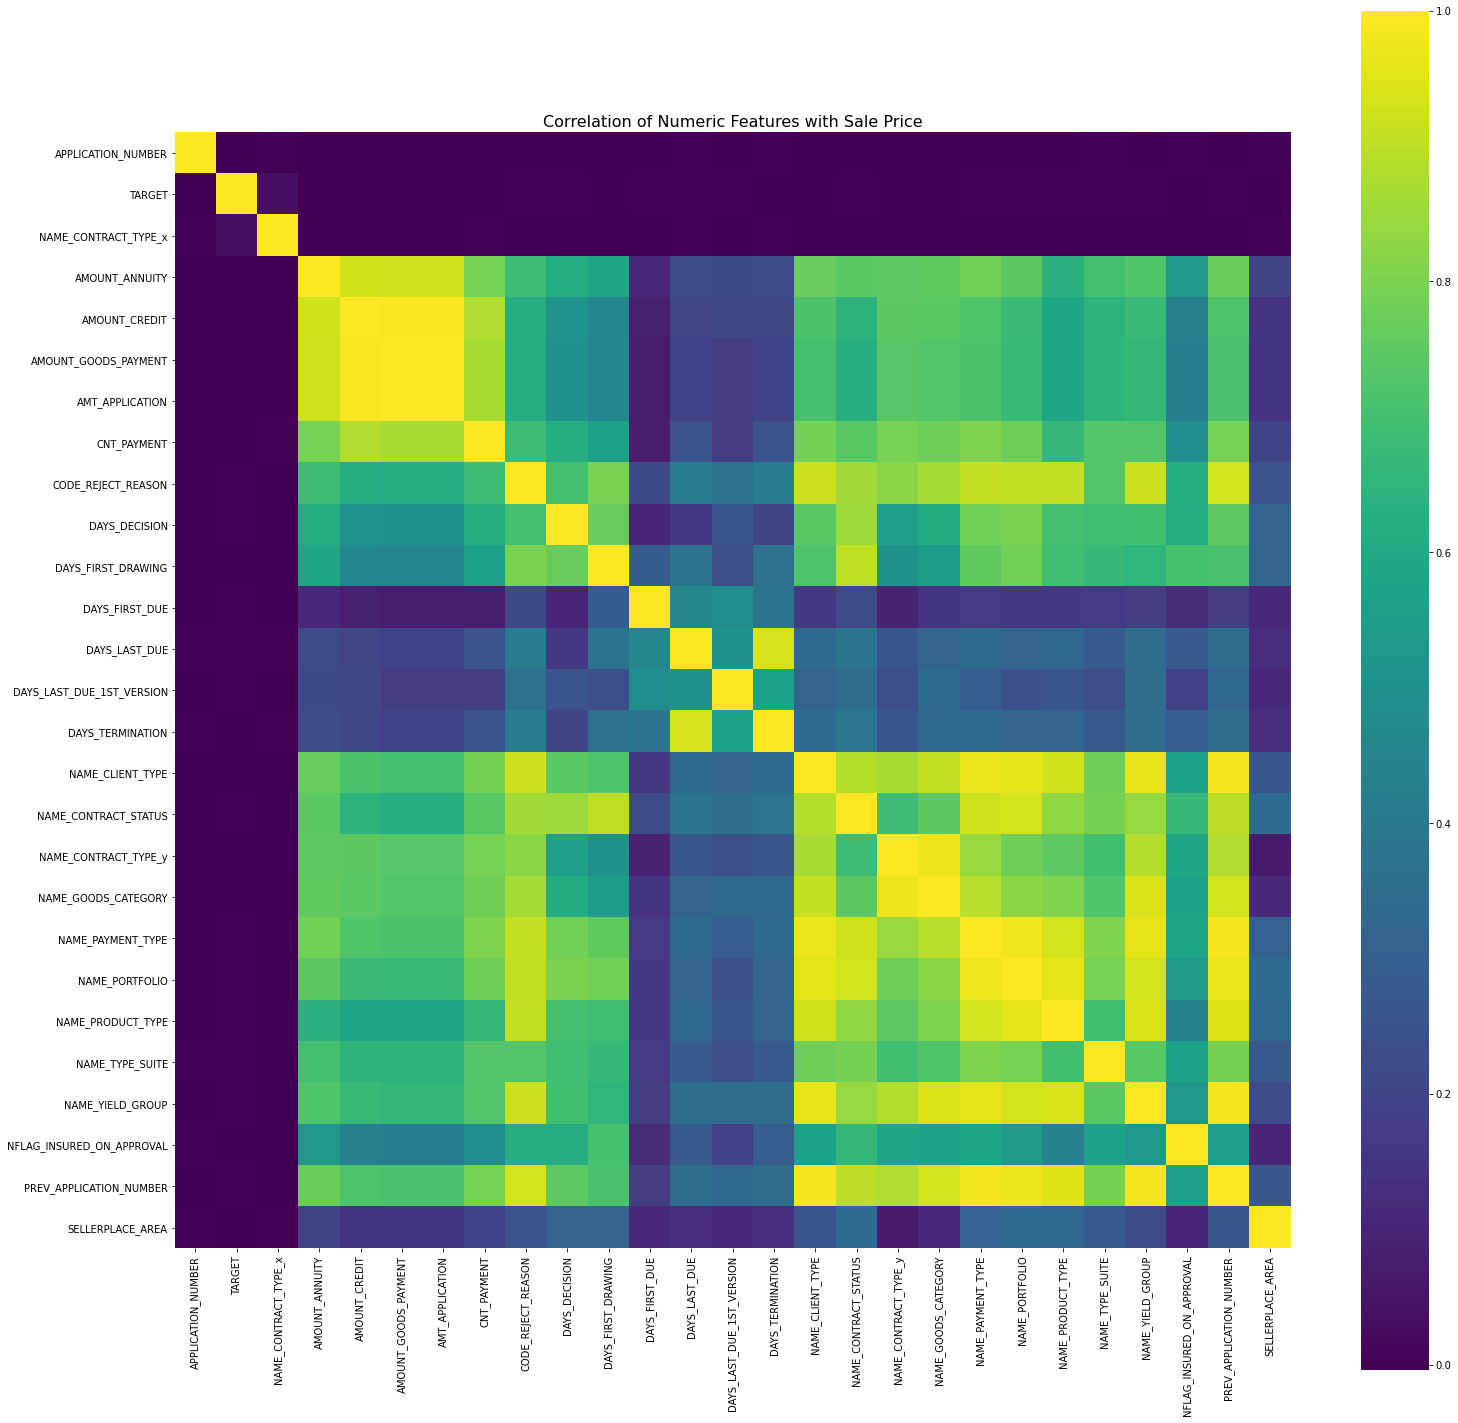

In [62]:
fig, axes = plt.subplots(figsize = (25,25))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(cor, square=True, vmax=1, cmap="viridis")

# данные БКИ о предыдущих кредитах клиента;
df_bki

In [ ]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# данные БКИ о предыдущих кредитах клиента;
df_bki = pd.read_csv(
    "../geekbrains-competitive-data-analysis/bki.csv"
)

print("bki.shape = {} rows, {} cols".format(*df_bki.shape))
df_bki.head()

In [ ]:
df_bki.info()

In [ ]:
msno.matrix(df_bki)

In [ ]:
numerical_features_df_bki = df_bki.select_dtypes(include=[np.number]).columns
numerical_features_df_bki = numerical_features_df_bki.drop('APPLICATION_NUMBER')

numerical_features_df_bki

CREDIT_ACTIVE, CREDIT_CURRENCY, CREDIT_TYPE

In [ ]:
df_bki['CREDIT_ACTIVE'].value_counts()

In [ ]:
df_bki['CREDIT_CURRENCY'].value_counts()

In [ ]:
df_bki['CREDIT_TYPE'].value_counts()

In [ ]:
df_bki = create_freq_feature(df_bki, 'CREDIT_ACTIVE')
df_bki = create_freq_feature(df_bki, 'CREDIT_CURRENCY')
df_bki = create_freq_feature(df_bki, 'CREDIT_TYPE')

DAYS_CREDIT_ENDDATE

In [ ]:
mean = df_bki.loc[df_bki['DAYS_CREDIT_ENDDATE'].notnull(), ['DAYS_CREDIT_ENDDATE']].mean()
df_bki['DAYS_CREDIT_ENDDATE'] = df_bki['DAYS_CREDIT_ENDDATE'].fillna(mean[0])

DAYS_ENDDATE_FACT

In [ ]:
df_bki.loc[df_bki['DAYS_ENDDATE_FACT'].isnull(), ['DAYS_ENDDATE_FACT']] = df_bki['DAYS_CREDIT_ENDDATE']

AMT_CREDIT_MAX_OVERDUE

In [ ]:
df_bki['AMT_CREDIT_MAX_OVERDUE'] = df_bki['AMT_CREDIT_MAX_OVERDUE'].fillna(0)

other

In [ ]:
df_bki.drop(['AMT_ANNUITY'], axis='columns', inplace=True)
numerical_features_df_bki = numerical_features_df_bki.drop('AMT_ANNUITY')

In [ ]:
df_bki = df_bki.fillna(0)

num

In [ ]:
df_bki = numeric_feature_preprocessing(df_bki, 
                                       numeric_feature=numerical_features_df_bki)

scale

In [ ]:
df_bki_scale = pd.DataFrame(standard_scaler.fit_transform(df_bki), 
               columns=df_bki.columns)

In [ ]:
df_bki_scale.drop(['APPLICATION_NUMBER', 'BUREAU_ID'], axis='columns', inplace=True)

In [ ]:
kmeans_bki = KMeans(n_clusters=10, max_iter=10000, random_state=1)

In [ ]:
%%time

kmeans_train_bki = kmeans_bki.fit_predict(df_bki_scale)

In [ ]:
df_bki_result = pd.DataFrame(pd.get_dummies(kmeans_train_bki, prefix='bki'))
df_bki_result_columns = df_bki_result.columns
df_bki_result['APPLICATION_NUMBER'] = df_bki['APPLICATION_NUMBER']

In [ ]:
df_bki_result = pd.pivot_table(df_bki_result, values=df_bki_result_columns, index=['APPLICATION_NUMBER'], aggfunc=np.sum)

In [ ]:
df_bki_result['sum'] = df_bki_result.sum(axis=1)
for col in df_bki_result_columns:
    df_bki_result[col] = df_bki_result[col] / df_bki_result['sum']
df_bki_result.drop(['sum'], axis='columns', inplace=True)  

# история платежей клиента;
df_payments

In [63]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# история платежей клиента;
df_payments = pd.read_csv(
    "../geekbrains-competitive-data-analysis/payments.csv"
)

print("payments.shape = {} rows, {} cols".format(*df_payments.shape))
df_payments.head()

payments.shape = 1023932 rows, 8 cols


,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945
3,48398897,123550846,0.0,82,398.0,398.0,7082.145,7082.145
4,49867197,123562174,0.0,63,1359.0,1359.0,156.735,156.735


In [64]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int64  
 1   APPLICATION_NUMBER       1023932 non-null  int64  
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float64
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int64  
 4   DAYS_INSTALMENT          1023932 non-null  float64
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float64
 6   AMT_INSTALMENT           1023932 non-null  float64
 7   AMT_PAYMENT              1023729 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 62.5 MB


In [65]:
numerical_features_df_payments = df_payments.select_dtypes(include=[np.number]).columns
numerical_features_df_payments = numerical_features_df_payments.drop('APPLICATION_NUMBER')
numerical_features_df_payments = numerical_features_df_payments.drop('PREV_APPLICATION_NUMBER')

numerical_features_df_payments

Index(['NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT',
       'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')

In [66]:
df_payments = df_payments.fillna(0)

In [67]:
# df_payments = numeric_feature_preprocessing(df_payments, 
#                                             numeric_feature=numerical_features_df_payments)

In [68]:
df_payments_scale = pd.DataFrame(standard_scaler.fit_transform(df_payments), 
               columns=df_payments.columns)

df_payments_scale.drop(['APPLICATION_NUMBER', 'PREV_APPLICATION_NUMBER'], axis='columns', inplace=True)

In [69]:
kmeans_payments = KMeans(n_clusters=10, max_iter=10000, random_state=1)

In [70]:
%%time

kmeans_train_payments = kmeans_payments.fit_predict(df_payments_scale)

Wall time: 28.8 s


In [71]:
df_payments_result = pd.DataFrame(pd.get_dummies(kmeans_train_payments, prefix='payments'))
df_payments_result_columns = df_payments_result.columns
df_payments_result['APPLICATION_NUMBER'] = df_payments['APPLICATION_NUMBER']

In [72]:
df_payments_result = pd.pivot_table(df_payments_result, values=df_payments_result_columns, index=['APPLICATION_NUMBER'], aggfunc=np.sum)

In [73]:
df_payments_result['sum'] = df_payments_result.sum(axis=1)
for col in df_payments_result_columns:
    df_payments_result[col] = df_payments_result[col] / df_payments_result['sum']
df_payments_result.drop(['sum'], axis='columns', inplace=True)  

In [74]:
df_train_payments = df_train.merge(df_payments_result, 
                                   left_on='APPLICATION_NUMBER', 
                                   right_on='APPLICATION_NUMBER', 
                                   how='inner')

cor = df_train_payments.corr()

df_train_payments, df_valid_payments = train_test_split(df_train_payments, 
                                                        test_size=0.3,  
                                                        random_state=42)

y_train_payments = df_train_payments["TARGET"]
y_valid_payments = df_valid_payments["TARGET"]

df_train_payments.drop(["TARGET", 'APPLICATION_NUMBER'], axis='columns', inplace=True)
df_valid_payments.drop(["TARGET", 'APPLICATION_NUMBER'], axis='columns', inplace=True)

print("df_train_payments = {} rows, {} cols".format(*df_train_payments.shape))
print("df_valid_payments.shape = {} rows, {} cols".format(*df_valid_payments.shape))

df_train_payments = 57376 rows, 11 cols
df_valid_payments.shape = 24591 rows, 11 cols


In [75]:
%%time
dtrain = lgb.Dataset(data=df_train_payments, label=y_train_payments)
dvalid = lgb.Dataset(data=df_valid_payments, label=y_valid_payments)

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.001,
    "n_estimators": 10000,
    "n_jobs": 4,
    "seed": 20
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=100,
    verbose_eval=500
)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	training's auc: 0.548633	valid_1's auc: 0.526684
Wall time: 908 ms


<AxesSubplot:title={'center':'Correlation of Numeric Features with Sale Price'}>

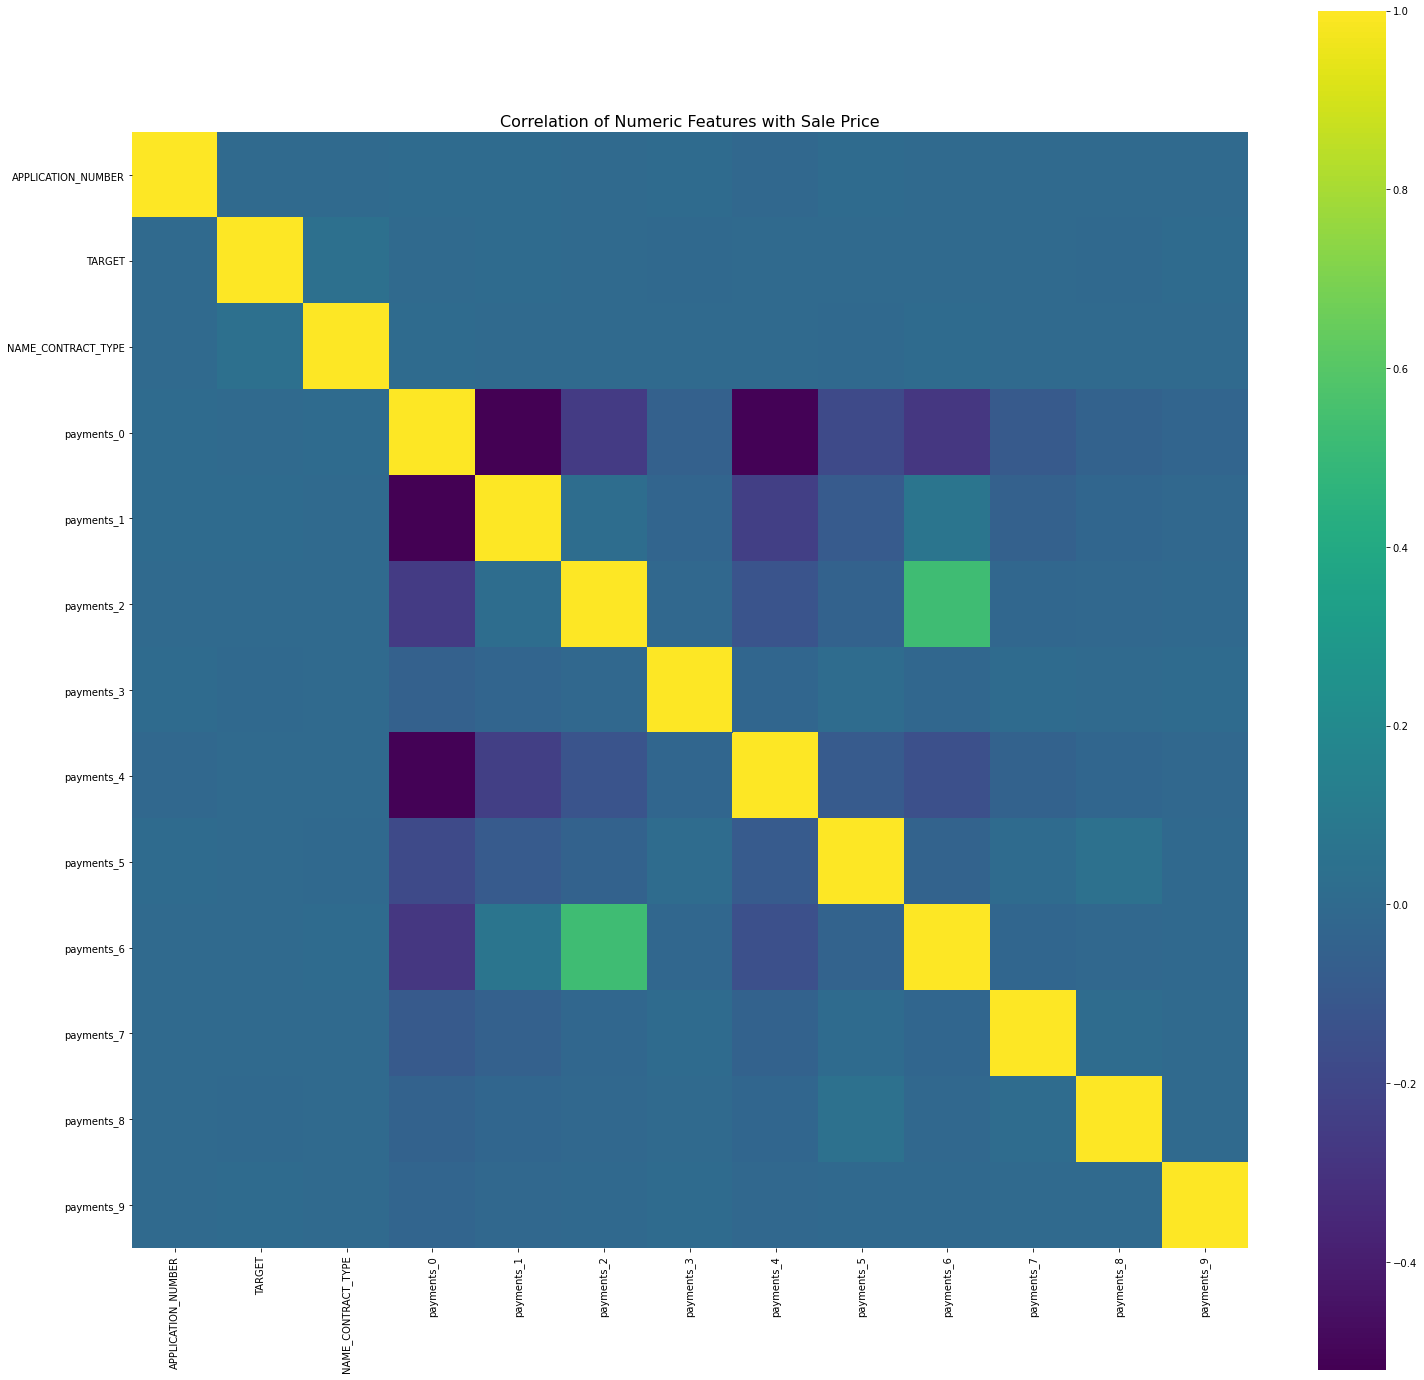

In [76]:
fig, axes = plt.subplots(figsize = (25,25))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(cor, square=True, vmax=1, cmap="viridis")

# клиентский профиль, некоторые знания, которые есть у компании о клиенте;
df_client_profile

In [ ]:
# клиентский профиль, некоторые знания, которые есть у компании о клиенте;
df_client_profile = pd.read_csv(
    "../geekbrains-competitive-data-analysis/client_profile.csv"
)

print("client_profile.shape = {} rows, {} cols".format(*df_client_profile.shape))
df_client_profile.head()

In [ ]:
df_client_profile.info()

In [ ]:
msno.matrix(df_client_profile)

GENDER

In [ ]:
df_client_profile['GENDER'].value_counts()

In [ ]:
df_client_profile['GENDER'] = (df_client_profile['GENDER'] == 'F').astype(int)

FAMILY_STATUS,EDUCATION_LEVEL

In [ ]:
df_client_profile['FAMILY_STATUS'].value_counts()

In [ ]:
df_client_profile['EDUCATION_LEVEL'].value_counts()

In [ ]:
df_client_profile = create_freq_feature(df_client_profile, 'FAMILY_STATUS')
df_client_profile = create_freq_feature(df_client_profile, 'EDUCATION_LEVEL')

In [ ]:
df_client_profile = df_client_profile.fillna(value=
                                             {'OWN_CAR_AGE': 0, 
                                              'EXTERNAL_SCORING_RATING_1': df_client_profile['EXTERNAL_SCORING_RATING_1'].min(),
                                              'EXTERNAL_SCORING_RATING_3': df_client_profile['EXTERNAL_SCORING_RATING_3'].min()
                                             })

df_client_profile = df_client_profile.fillna(0)

# Объединение

In [ ]:
df_train = pd.read_csv(
    "../geekbrains-competitive-data-analysis/train.csv"
)

df_test = pd.read_csv(
    "../geekbrains-competitive-data-analysis/test.csv"
)

print("gf_train.shape = {} rows, {} cols".format(*df_train.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))

In [ ]:
#df_train = create_dummie(df_train)
#df_test = create_dummie(df_test)

df_train['NAME_CONTRACT_TYPE'] = (df_train['NAME_CONTRACT_TYPE'] == 'Cash').astype(int)
df_test['NAME_CONTRACT_TYPE'] = (df_test['NAME_CONTRACT_TYPE'] == 'Cash').astype(int)

## Профиль клиента

In [ ]:
df_train_client_profile = df_train.merge(df_client_profile, 
                                         left_on='APPLICATION_NUMBER', 
                                         right_on='APPLICATION_NUMBER', 
                                         how='inner')

In [ ]:
df_train_client_profile, df_valid_client_profile = train_test_split(df_train_client_profile, test_size=0.3,  random_state=42)

In [ ]:
y_train_client_profile = df_train_client_profile["TARGET"]
y_valid_client_profile = df_valid_client_profile["TARGET"]

df_train_client_profile.drop(["TARGET", 'APPLICATION_NUMBER'], axis='columns', inplace=True)
df_valid_client_profile.drop(["TARGET", 'APPLICATION_NUMBER'], axis='columns', inplace=True)

print("df_train_client_profile.shape = {} rows, {} cols".format(*df_train_client_profile.shape))
print("df_valid_client_profile.shape = {} rows, {} cols".format(*df_valid_client_profile.shape))

In [ ]:
%%time
dtrain = lgb.Dataset(data=df_train_client_profile, label=y_train_client_profile)
dvalid = lgb.Dataset(data=df_valid_client_profile, label=y_valid_client_profile)

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.001,
    "n_estimators": 10000,
    "n_jobs": 4,
    "seed": 20
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=500
)

In [ ]:
df_test_client_profile = df_test.merge(df_client_profile, 
                                       left_on='APPLICATION_NUMBER', 
                                       right_on='APPLICATION_NUMBER', 
                                       how='inner')
test_client_profile_application_number = df_test_client_profile['APPLICATION_NUMBER']
df_test_client_profile.drop(['APPLICATION_NUMBER'], axis='columns', inplace=True)

pred = model_lgb.predict(df_test_client_profile)

application_number_pred = pd.DataFrame(pred, columns=['client_profile'])
application_number_pred['APPLICATION_NUMBER'] = test_client_profile_application_number

## БКИ

In [ ]:
df_train_bki = df_train.merge(df_applications_history_result, 
                                               left_on='APPLICATION_NUMBER', 
                                               right_on='APPLICATION_NUMBER', 
                                               how='inner')

df_train_bki, df_valid_bki = train_test_split(df_train_bki, 
                                              test_size=0.3,  
                                              random_state=42)

y_train_bki = df_train_bki["TARGET"]
y_valid_bki = df_valid_bki["TARGET"]

df_train_bki.drop(["TARGET", 'APPLICATION_NUMBER'], axis='columns', inplace=True)
df_valid_bki.drop(["TARGET", 'APPLICATION_NUMBER'], axis='columns', inplace=True)

print("df_train_bki.shape = {} rows, {} cols".format(*df_train_bki.shape))
print("df_valid_bki.shape = {} rows, {} cols".format(*df_valid_bki.shape))

In [ ]:
%%time
dtrain = lgb.Dataset(data=df_train_bki, label=y_train_bki)
dvalid = lgb.Dataset(data=df_valid_bki, label=y_valid_bki)

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.001,
    "n_estimators": 10000,
    "n_jobs": 4,
    "seed": 20
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=100,
    verbose_eval=500
)

In [ ]:
df_bki

In [ ]:
print("gf_train.shape = {} rows, {} cols".format(*df_train.shape))
print("df_valid.shape = {} rows, {} cols".format(*df_valid.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))

In [ ]:
df_train = df_train.merge(df_applications_history_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_valid = df_valid.merge(df_applications_history_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_test = df_test.merge(df_applications_history_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')

In [ ]:
df_train = df_train.merge(df_bki_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_valid = df_valid.merge(df_bki_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_test = df_test.merge(df_bki_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')

In [ ]:
df_train = df_train.merge(df_payments_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_valid = df_valid.merge(df_payments_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_test = df_test.merge(df_payments_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')

In [ ]:
cor = df_train.corr()
fig, axes = plt.subplots(figsize = (25,25))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(cor, square=True, vmax=1, cmap="viridis")

In [ ]:
y_train = df_train["TARGET"]
y_valid = df_valid["TARGET"]

df_train.drop(["TARGET", 'APPLICATION_NUMBER'], axis='columns', inplace=True)
df_valid.drop(["TARGET", 'APPLICATION_NUMBER'], axis='columns', inplace=True)

In [ ]:
df_test.drop(['APPLICATION_NUMBER'], axis='columns', inplace=True)

In [ ]:
print("df_train.shape = {} rows, {} cols".format(*df_train.shape))
print("df_valid.shape = {} rows, {} cols".format(*df_valid.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))

In [ ]:
df_train.describe().T

In [ ]:
msno.matrix(df_train)

In [ ]:
msno.matrix(df_test)

In [ ]:
# %%time

# dtrain = xgb.DMatrix(data=df_train.fillna(0), label=y_train)
# print('*')
# dvalid = xgb.DMatrix(data=df_valid.fillna(0), label=y_valid)
# print('*')
# dtest = xgb.DMatrix(data=df_test.fillna(0))

In [ ]:
# %%time

# params = {
#     "booster": "gbtree",
#     "objective": "binary:logistic",
#     "eval_metric": "auc",
#     "learning_rate": 0.01,
#     "n_estimators": 1000,
#     "reg_lambda": 100,
#     "max_depth": 10,
#     "gamma": 10,
#     "nthread": 6,
#     "seed": 27
# }

# model_xgb = xgb.train(
#     params=params,
#     dtrain=dtrain,
#     num_boost_round=1000,
#     early_stopping_rounds=50,
#     evals=[(dtrain, "train"), (dvalid, "valid")],
#     verbose_eval=100,
#     maximize=True,
# )

In [ ]:
%%time

dtrain = lgb.Dataset(data=df_train.fillna(0), label=y_train)
dvalid = lgb.Dataset(data=df_valid.fillna(0), label=y_valid)
dtest = lgb.Dataset(data=df_test.fillna(0))

In [ ]:
%%time

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 5000,
    "n_jobs": 6,
    "seed": 27
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=100
)

In [ ]:
result = model_lgb.predict(df_test.fillna(0))
result

In [ ]:
df_sample_submit["TARGET"] = df_sample_submit["TARGET"].astype('float')

In [ ]:
df_sample_submit["TARGET"] = result

In [ ]:
df_sample_submit.to_csv('result.csv', index=False) 

In [ ]:
model_lgb.feature_importance()

In [ ]:
feature = pd.DataFrame(data=[model_lgb.feature_importance()], columns=model_lgb.feature_name())

In [ ]:
feature